<a href="https://colab.research.google.com/github/Anirban-Purakayastha/Dermacare/blob/main/skinProb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle

# Download dataset
!kaggle datasets download -d ismailpromus/skin-diseases-image-dataset

# Unzip
import zipfile
with zipfile.ZipFile("skin-diseases-image-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("skin_diseases")

Dataset URL: https://www.kaggle.com/datasets/ismailpromus/skin-diseases-image-dataset
License(s): copyright-authors


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

In [5]:
data_dir = "skin_diseases/IMG_CLASSES"

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 21726 images belonging to 10 classes.
Found 5427 images belonging to 10 classes.


In [6]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze ResNet50 base


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_gen.num_classes, activation='softmax')  # Output layer
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [8]:
base_model.trainable = True

# Freeze all layers except the top few
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower LR for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_gen, validation_data=val_gen, epochs=5)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
679/679 ━━━━━━━━━━━━━━━━━━━━ 513s 723ms/step - accuracy: 0.3768 - loss: 1.7709 - val_accuracy: 0.2460 - val_loss: 2.0597
Epoch 2/5
679/679 ━━━━━━━━━━━━━━━━━━━━ 453s 668ms/step - accuracy: 0.5092 - loss: 1.2836 - val_accuracy: 0.2661 - val_loss: 1.9154
Epoch 3/5
679/679 ━━━━━━━━━━━━━━━━━━━━ 429s 632ms/step - accuracy: 0.5347 - loss: 1.2043 - val_accuracy: 0.3599 - val_loss: 1.7841
Epoch 4/5
679/679 ━━━━━━━━━━━━━━━━━━━━ 423s 623ms/step - accuracy: 0.5543 - loss: 1.1684 - val_accuracy: 0.2427 - val_loss: 2.6222
Epoch 5/5
679/679 ━━━━━━━━━━━━━━━━━━━━ 424s 625ms/step - accuracy: 0.5620 - loss: 1.1318 - val_accuracy: 0.2624 - val_loss: 2.1235


Epoch 1/5
679/679 ━━━━━━━━━━━━━━━━━━━━ 431s 635ms/step - accuracy: 0.5750 - loss: 1.1062 - val_accuracy: 0.3247 - val_loss: 1.9661
Epoch 2/5
679/679 ━━━━━━━━━━━━━━━━━━━━ 430s 633ms/step - accuracy: 0.5813 - loss: 1.0849 - val_accuracy: 0.2790 - val_loss: 2.2444
Epoch 3/5
679/679 ━━━━━━━━━━━━━━━━━━━━ 433s 638ms/step - accuracy: 0.5914 - loss: 1.0608 - val_accuracy: 0.2292 - val_loss: 3.0324
Epoch 4/5
679/679 ━━━━━━━━━━━━━━━━━━━━ 430s 634ms/step - accuracy: 0.5836 - loss: 1.0654 - val_accuracy: 0.3573 - val_loss: 2.2553
Epoch 5/5
679/679 ━━━━━━━━━━━━━━━━━━━━ 426s 627ms/step - accuracy: 0.5967 - loss: 1.0354 - val_accuracy: 0.3164 - val_loss: 2.4824


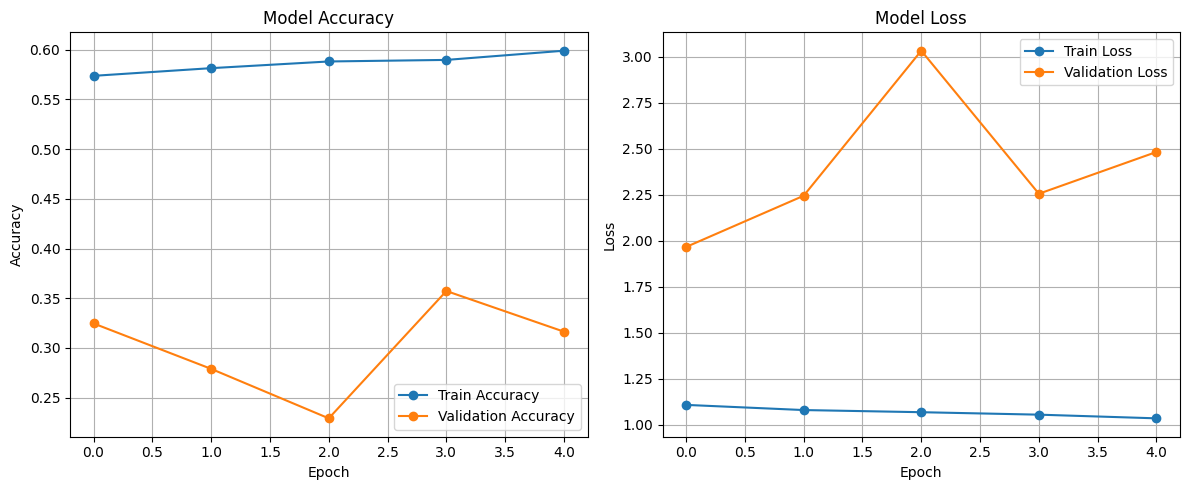

In [10]:
import matplotlib.pyplot as plt

# ... (previous code) ...

history = model.fit(train_gen, validation_data=val_gen, epochs=5) # Assign the result of model.fit to history

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [11]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def predict_skin_disease(model, img_path, class_indices, target_size=(224, 224)):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Rescale
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    # Reverse the class_indices dictionary
    class_labels = {v: k for k, v in class_indices.items()}

    # Plot image with predicted label
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {class_labels[predicted_class]}")
    plt.show()

    return class_labels[predicted_class]
